# NHL Jets - Event Propensity - Next Event Buyer Model
* Ryan Kazmerik, Nakisa Rad, Joey Lai, Shawn Sutherland, Matt Bahler, Pat Faith
* Mar 03, 2022

## Hypothesis
Each team has different tier (or quality) of games, based on day of the week, time of the season, opponent, etc. We think that by using previous buyer behaviour we can make a prediction on whether the fan will purchase for the next game or not.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [5]:
import getpass
import matplotlib.pyplot as plt
import pyodbc
import pandas as pd
import warnings

from pycaret.classification import *

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [ ]:
# connect to SQL Server.
SERVER = '34.206.73.189'  
DATABASE = 'stlrNHLJets' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
cursor = CNXN.cursor()

query = "SELECT * FROM datascience.yankees.event_propensity_training_noFirstPurchases2"
    
df = pd.read_sql(query, CNXN)
    
CNXN.commit()
cursor.close()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266386 entries, 0 to 266385
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   daysOut              266386 non-null  object        
 1   minDaysOut           266386 non-null  int64         
 2   maxDaysOut           147819 non-null  float64       
 3   dimCustomerMasterId  266386 non-null  int64         
 4   recent_openRate      266386 non-null  float64       
 5   recent_clickRate     266386 non-null  float64       
 6   eventDate            266386 non-null  datetime64[ns]
 7   eventName            266386 non-null  object        
 8   inMarket             242800 non-null  object        
 9   distanceToVenue      242800 non-null  float64       
 10  tenure               266386 non-null  int64         
 11  did_purchase         266386 non-null  int64         
 12  events_purchased     266386 non-null  int64         
 13  frequency_oppo

### We should create separate out some data for training the model and some for evaluating:

In [5]:
# copy your main dataframe
df_dataset = df

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True)
df_eval.reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

df_train.info()

Data for Modeling: (226428, 16)
Unseen Data For Predictions: (39958, 16)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226428 entries, 158559 to 178255
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   daysOut              226428 non-null  object        
 1   minDaysOut           226428 non-null  int64         
 2   maxDaysOut           125558 non-null  float64       
 3   dimCustomerMasterId  226428 non-null  int64         
 4   recent_openRate      226428 non-null  float64       
 5   recent_clickRate     226428 non-null  float64       
 6   eventDate            226428 non-null  datetime64[ns]
 7   eventName            226428 non-null  object        
 8   inMarket             206404 non-null  object        
 9   distanceToVenue      206404 non-null  float64       
 10  tenure               226428 non-null  int64         
 11  did_purchase         226428 non-null  int64        

### Now we can model the data using a binary classification prediction for the target field to see how likely a customer is to purchase:

In [6]:
setup(
    data= df_train, 
    target="did_purchase", 
    train_size = 0.80,
    data_split_shuffle=True,
    categorical_features=["inMarket"],
    date_features=["eventDate"],
    ignore_features=[
        "dimCustomerMasterId",
        "eventName",
        "minDaysOut",
        "maxDaysOut"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "distanceToVenue",
        "events_purchased",
        "frequency_eventDay",
        "frequency_opponent",
        "frequency_eventTime",
        "recent_clickRate",
        "recent_openRate",
        "tenure"
    ]
);

In [7]:
model_matrix = compare_models(
    fold= 10, 
    include= ["lr"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8017,0.8787,0.7834,0.8132,0.7980,0.6035,0.6039,4.9570


### The top model is performing well, so let's compare it against our test dataset:

In [8]:
best_model = create_model(
    model_matrix, 
    fold= 10
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8026,0.8780,0.7809,0.8163,0.7982,0.6052,0.6058
1,0.8029,0.8796,0.7860,0.8134,0.7995,0.6057,0.6061
2,0.7997,0.8777,0.7768,0.8140,0.7950,0.5993,0.5999
3,0.8032,0.8802,0.7881,0.8127,0.8002,0.6065,0.6068
4,0.7945,0.8759,0.7801,0.8031,0.7915,0.5889,0.5892
5,0.7981,0.8752,0.7815,0.8082,0.7946,0.5961,0.5964
6,0.8090,0.8819,0.7909,0.8205,0.8054,0.6180,0.6184
7,0.8066,0.8836,0.7846,0.8206,0.8022,0.6132,0.6138
8,0.7989,0.8760,0.7798,0.8107,0.7949,0.5978,0.5982
9,0.8020,0.8789,0.7853,0.8124,0.7986,0.6041,0.6044


### Let's load in our evaluation data and get propensity scores using the model:

In [9]:
df_inference = predict_model(best_model, data=df_eval, raw_score=True)
df_inference.head()

,daysOut,minDaysOut,maxDaysOut,dimCustomerMasterId,recent_openRate,recent_clickRate,eventDate,eventName,inMarket,distanceToVenue,tenure,did_purchase,events_purchased,frequency_opponent,frequency_eventDay,frequency_eventTime,Label,Score_0,Score_1
3,1 to 3 Days Out,1,4.0,1488,0.00,0.0,2019-08-03,20190803 - Boston Red Sox,True,50.53,122,0,52,0.000000,0.000000,0.000000,0,0.6967,0.3033
8,1 to 3 Days Out,1,4.0,1980,0.25,0.0,2017-09-30,20170930 - Toronto Blue Jays,True,85.07,177,1,77,0.285714,0.545455,0.428571,1,0.0039,0.9961
13,1 to 3 Days Out,1,4.0,3071,0.00,0.0,2021-05-05,20210505 - Houston Astros,True,31.05,1387,0,219,0.000000,0.000000,0.000000,0,0.8465,0.1535
29,1 to 3 Days Out,1,4.0,8115,0.00,0.0,2018-05-09,20180509 - Boston Red Sox,True,23.24,350,1,78,0.181818,0.000000,0.113636,1,0.3289,0.6711
37,1 to 3 Days Out,1,4.0,10753,0.00,0.0,2017-06-08,20170608 - Boston Red Sox,True,25.47,106,0,26,0.000000,0.000000,0.000000,0,0.7440,0.2560


### Included are some metrics on did and did_not purchase:

In [10]:
did_purchase = df_inference["Label"].value_counts()[1]
did_not_purchase = df_inference["Label"].value_counts()[0]
total_rows = df_inference["Label"].count()
purchase_percentage = round((did_purchase / total_rows), 2) * 100

print("Would purchase:", did_purchase)
print("Would not purchase:", did_not_purchase)
print("Purchase percentage:", purchase_percentage)

Would purchase: 19158
Would not purchase: 20800
Purchase percentage: 48.0


### We can also see the correlation between the features and the target variable:

In [11]:
cor = df.corr()

df_correlated = df

corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,minDaysOut,maxDaysOut,dimCustomerMasterId,recent_openRate,recent_clickRate,distanceToVenue,tenure,did_purchase,events_purchased,frequency_opponent,frequency_eventDay,frequency_eventTime
minDaysOut,1.00,0.98,0.10,-0.10,-0.05,-0.09,-0.03,0.36,0.02,-0.05,0.02,-0.06
maxDaysOut,0.98,1.00,0.01,-0.05,-0.01,0.01,0.07,-0.03,0.06,-0.15,-0.10,-0.16
dimCustomerMasterId,0.10,0.01,1.00,0.10,0.04,-0.14,0.06,0.39,0.07,0.13,0.13,0.12
recent_openRate,-0.10,-0.05,0.10,1.00,0.14,-0.03,-0.02,0.08,-0.03,0.09,0.06,0.10
recent_clickRate,-0.05,-0.01,0.04,0.14,1.00,-0.03,-0.03,0.07,-0.03,0.04,0.04,0.04
distanceToVenue,-0.09,0.01,-0.14,-0.03,-0.03,1.00,0.02,-0.24,-0.00,-0.06,-0.08,-0.09
tenure,-0.03,0.07,0.06,-0.02,-0.03,0.02,1.00,-0.13,0.95,-0.13,-0.18,-0.23
did_purchase,0.36,-0.03,0.39,0.08,0.07,-0.24,-0.13,1.00,-0.05,0.27,0.29,0.29
events_purchased,0.02,0.06,0.07,-0.03,-0.03,-0.00,0.95,-0.05,1.00,-0.12,-0.16,-0.22
frequency_opponent,-0.05,-0.15,0.13,0.09,0.04,-0.06,-0.13,0.27,-0.12,1.00,0.44,0.59


### Here we can see the distribution of fans who did and did not purchase : Score_0 = Did Not Purchase, Score_1 = Did Purchase

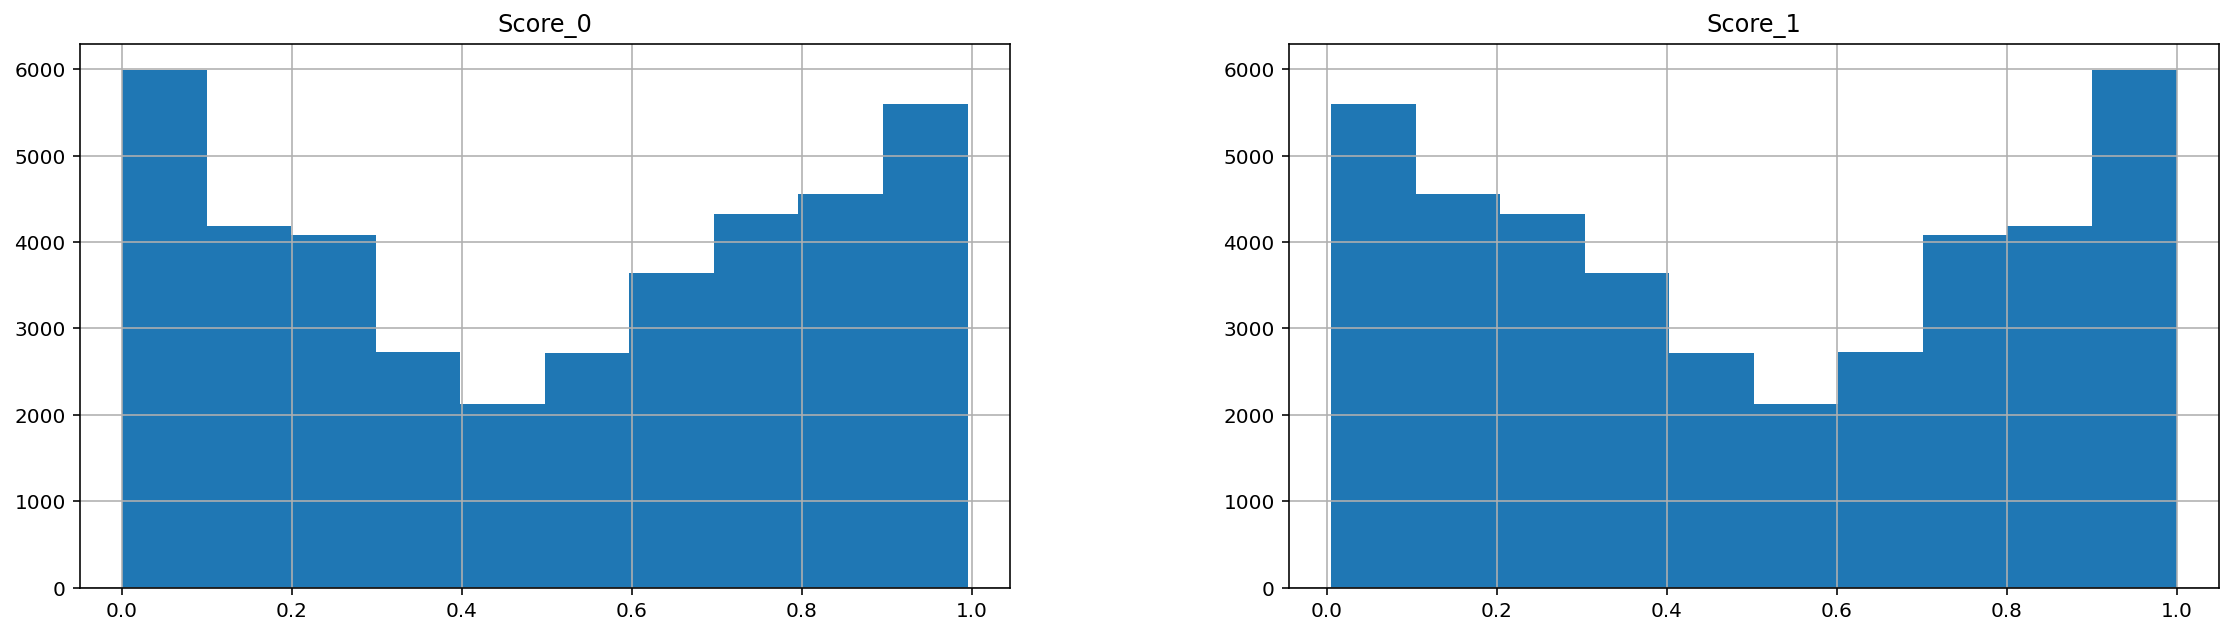

In [12]:
df_inference.hist(column=['Score_0', 'Score_1'], figsize=(30,5), layout=(1,3));

### This plot lists the most important features for a correct prediction (either Score_0 or Score_1) in the model:

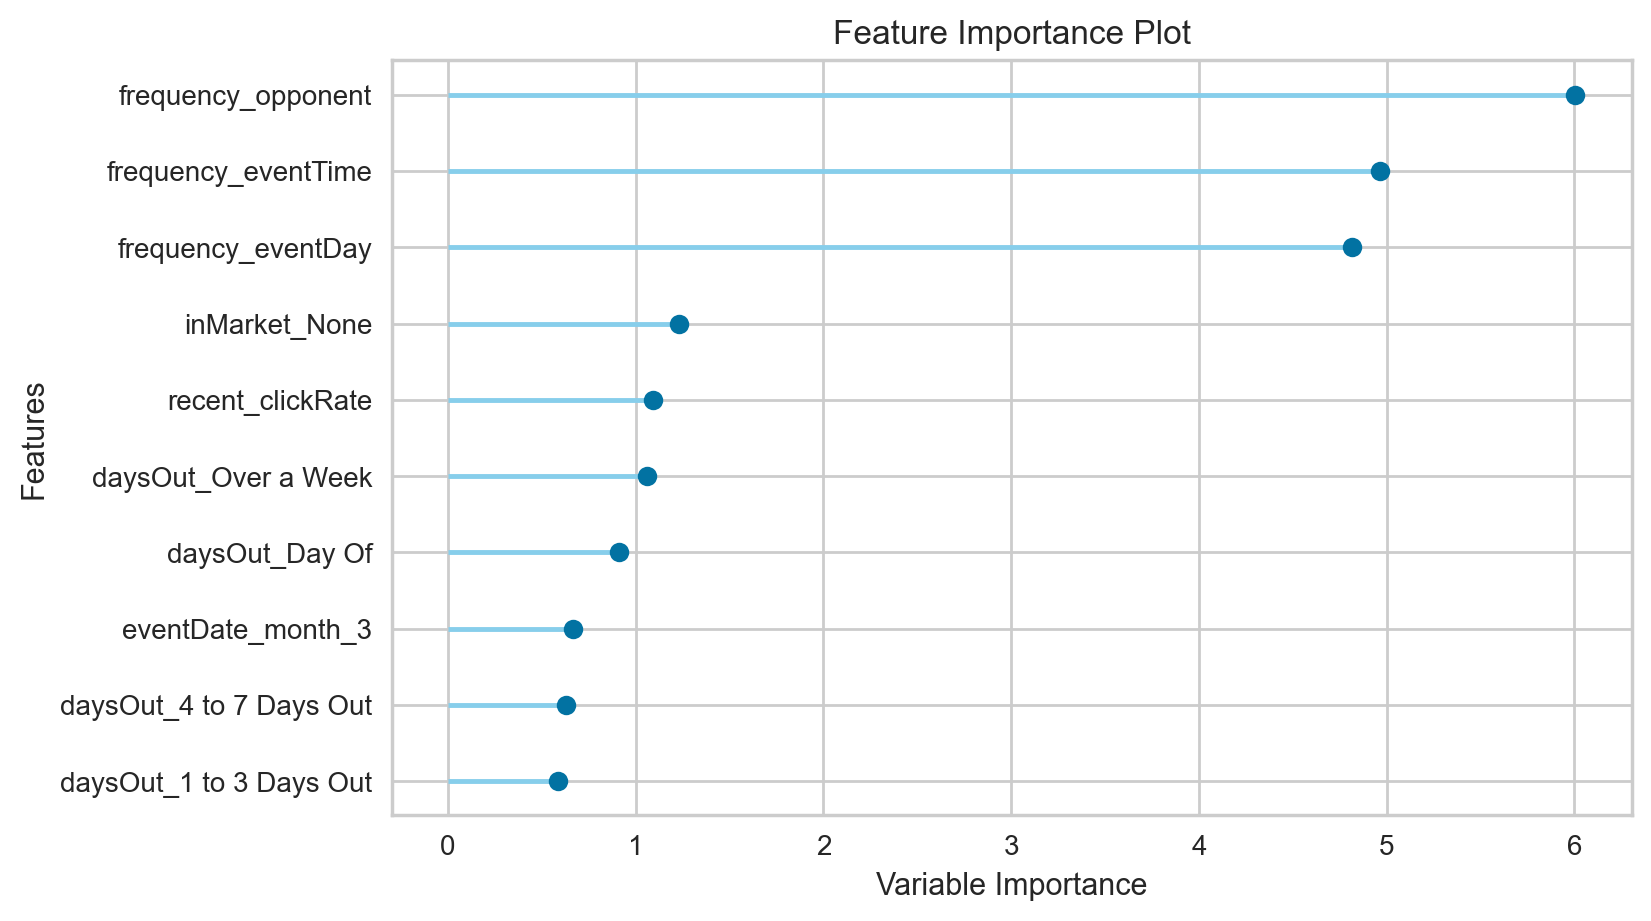

In [13]:
plot_model(best_model, plot='feature')

### This confusion matrix helps understand where the model guessed correctly or incorrectly based on the evaluation data:

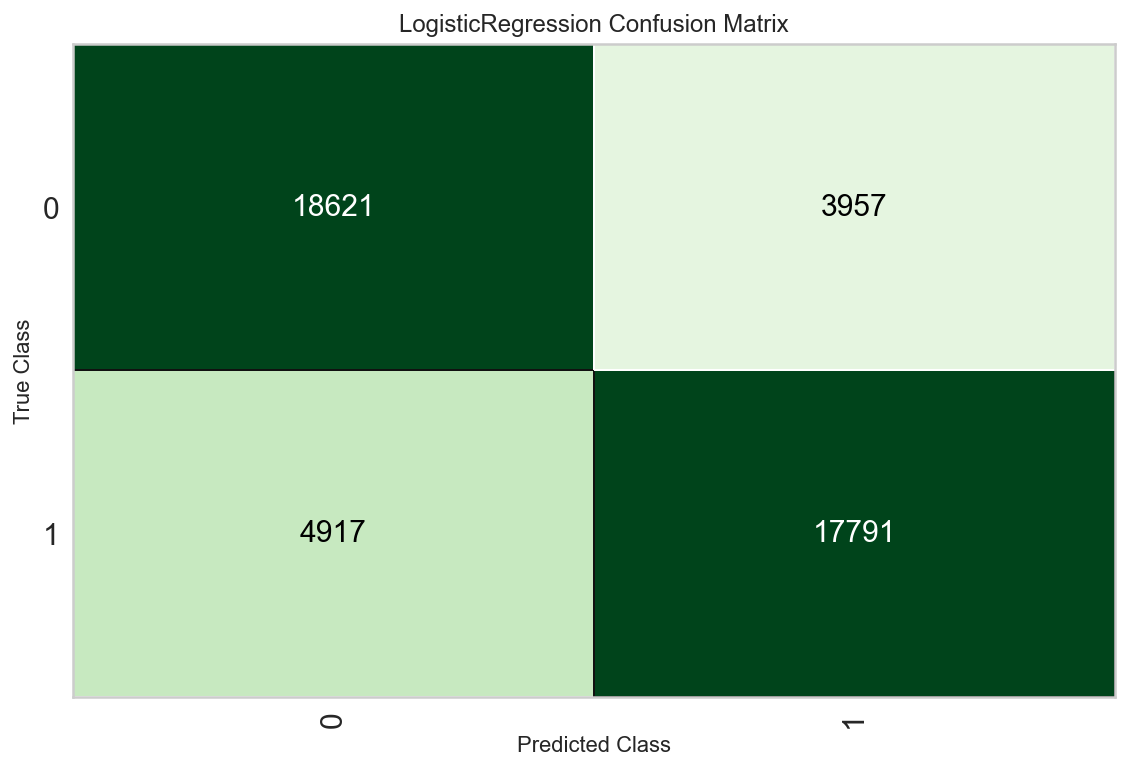

In [14]:
plot_model(best_model, plot='confusion_matrix')

### The AUC curve tells how much the model is capable of distinguishing between classes. The higher the curve, the better the model is at distiguishing classes:

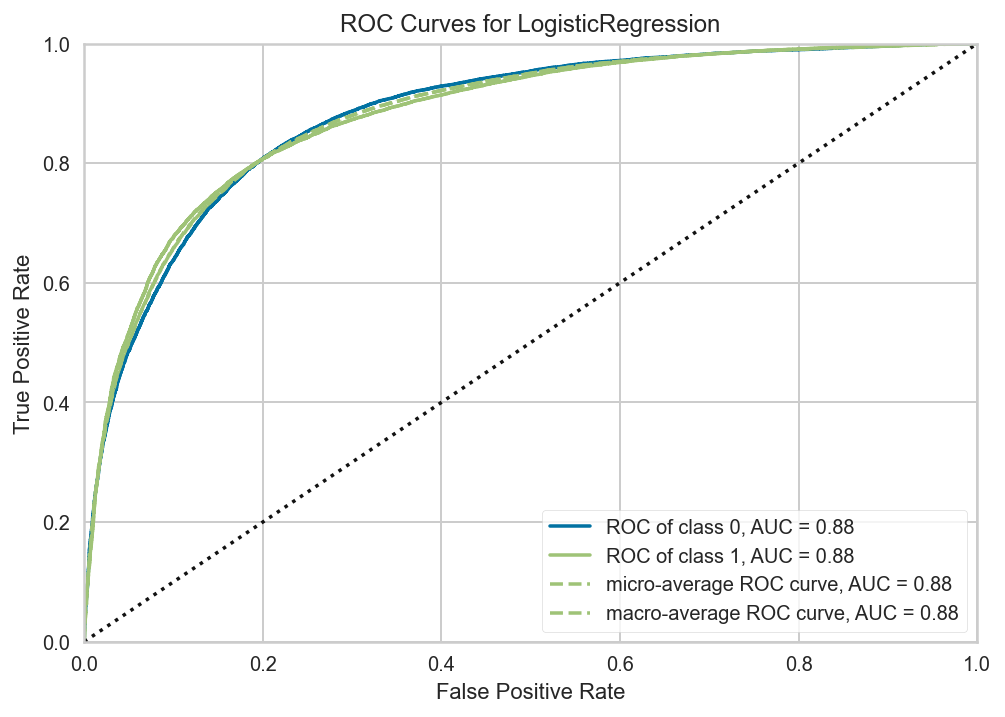

In [15]:
plot_model(best_model, plot='auc')

### Now we can save the model so in the future we can run different datasets through the model for predictions:

In [ ]:
save_model(best_model,'./models/MLB Yankees - Event Propensity(22Feb2022)')

## Observations
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?